In [ ]:
!pip install wurlitzer 
!pip install tensorflow

In [1]:
import tensorflow as tf

if tf.test.gpu_device_name():

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:

    print("Please install GPU version of TF")

2024-05-21 08:38:07.688373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 08:38:07.688425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 08:38:07.689806: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Default GPU Device: /device:GPU:0


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
tf.__version__

'2.15.0'

In [ ]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

def set_global_batch_size(BATCH_SIZE, strategy):
    '''
    Args:
        batch_size_per_replica (int) - batch size per replica
        strategy (tf.distribute.Strategy) - distribution strategy
    '''
    
    # set the global batch size
    ### START CODE HERE ###
    global_batch_size = BATCH_SIZE * strategy.num_replicas_in_sync
    ### END CODD HERE ###
    
    return global_batch_size

GLOBAL_BATCH_SIZE = set_global_batch_size(64, strategy)

In [3]:
Input_Shape = (224,224)
def train_val_generators(DATA_DIR, validation_split=0.2,):

    train_datagen = ImageDataGenerator(
        rescale=1./255.,
        zoom_range=0.3,
        rotation_range=20,
        brightness_range=0.3
        validation_split=validation_split  # Set the validation split
    )


    validation_datagen = ImageDataGenerator(rescale=1./255., validation_split=validation_split)


    train_generator = train_datagen.flow_from_directory(
        directory=DATA_DIR,
        batch_size=GLOBAL_BATCH_SIZE,
        target_size=(Input_Shape),
        class_mode='categorical', 
        subset='training'  
    )

    # Pass in the appropriate arguments to the flow_from_directory method for validation data
    validation_generator = validation_datagen.flow_from_directory(
        directory=DATA_DIR,
        batch_size=GLOBAL_BATCH_SIZE,
        target_size=(Input_Shape),
        class_mode='categorical', 
        subset='validation'  
    )

    ### END CODE HERE
    return train_generator, validation_generator


In [4]:
train_generator, validation_generator =train_val_generators("/kaggle/input/basic-ingredients/Dataset")

Found 637 images belonging to 4 classes.
Found 157 images belonging to 4 classes.


In [5]:
print (len(train_generator.class_indices))

4


In [6]:
def create_pre_trained_model():
    pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                              include_top=False,
                                              weights=None,)


  # Make all the layers in the pre-trained model non-trainable
    for layer in pre_trained_model.layers:
        layer.trainable = False

  ### END CODE HERE

    return pre_trained_model

In [7]:
pre_trained_model = create_pre_trained_model()
# pre_trained_model.summary()

9406464/9406464 [==============================] - 0s 0us/step


In [8]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 2,257,984 total parameters in this model.
There are 0 trainable parameters in this model.


In [9]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("val_loss") > logs.get("loss") + 0.02 :
            print("Overfit detected, intercepting")
            self.stopped_epoch = epoch
            self.model.stop_training = True

In [10]:
def create_final_model(pre_trained_model):
# Create the Sequential model
    model = tf.keras.Sequential([
        create_pre_trained_model(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')  # Adjusted for 4 classes
    ])

    # Compile the model
    model.compile(
        optimizer='adam', 
        loss='categorical_crossentropy',  # Changed to 'categorical_crossentropy' for multi-class classification
        metrics=['accuracy']  # Note: 'val_loss' is not a valid metric here
    )

    return model

In [13]:
model = create_final_model(pre_trained_model)
# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")
model.summary()

There are 3,573,828 total parameters in this model.
There are 1,315,844 trainable parameters in this model.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
              

In [14]:
callbacks = myCallback()
model.fit(history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 10,
                    callbacks=callbacks)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10


I0000 00:00:1716280787.262920     147 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 34s 3s/step - loss: 0.5858 - accuracy: 0.7802 - val_loss: 0.1463 - val_accuracy: 0.9618
Epoch 2/10
10/10 [==============================] - 21s 2s/step - loss: 0.0748 - accuracy: 0.9702 - val_loss: 0.2190 - val_accuracy: 0.9299


In [ ]:
#MULTIPLE-GPU
#Multiple-GPU
# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model =  create_final_model(pre_trained_model)

# Train the model on all available devices.
model.fit(history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 10,
                    callbacks=callbacks)

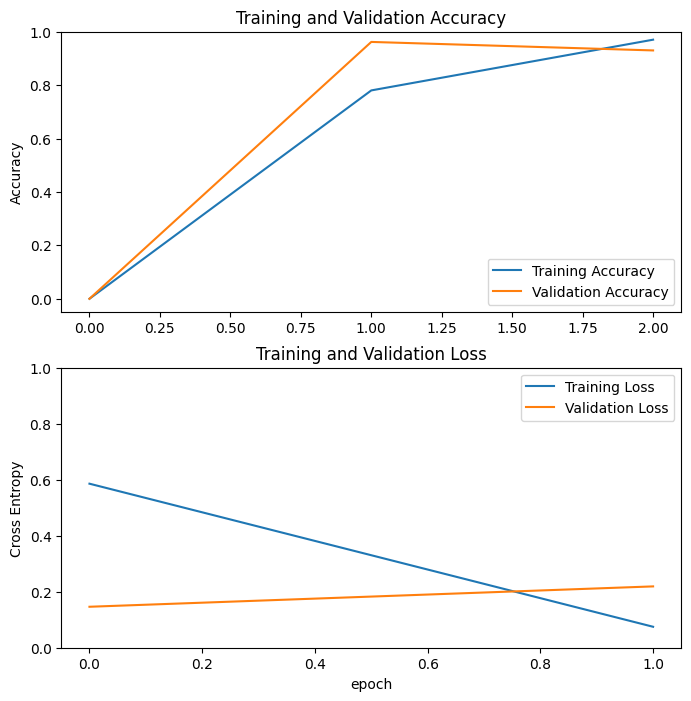

In [15]:
import matplotlib.pyplot as plt
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save("/kaggle/working/godpls.keras")

In [ ]:
model = tf.keras.models.load_model('godpls.keras')

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('class.txt', 'w') as f:
  f.write(labels)

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


# List of class names in the same order as the training labels
def load_class_names(filepath):
    with open(filepath, 'r') as file:
        class_names = file.read().splitlines()
    return class_names

# Path to the class names file
class_names_file = 'class.txt'

# Load class names from the file
class_names = load_class_names(class_names_file)  # Replace with your actual class names

def preprocess_image(img_path, target_size):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    # Expand dimensions to match the shape the model expects
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the image (this depends on how your model was trained, e.g., rescale to [0, 1] or [-1, 1])
    img_array = img_array / 255.0
    return img_array

def predict_image(model, img_array):
    # Get predictions
    predictions = model.predict(img_array)
    return predictions

# Define the path to your image and the target size
img_path = '/kaggle/input/basic-ingredients/Dataset/chicken/Image_120.jpg'
target_size = (224, 224)  # Change this to the input size of your model

# Preprocess the image
img_array = preprocess_image(img_path, target_size)

# Predict the class
predictions = predict_image(model, img_array)

# Assuming a categorical model with softmax output
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Get the class name
confidence_score = np.max(predictions, axis=1)[0]
predicted_class_name = class_names[predicted_class_index]

print(f'Predicted class: {predicted_class_name}')
print(f'Confidence score: {confidence_score}')